In [1]:
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from pathlib import Path

env_path = Path('../env')
load_dotenv(dotenv_path=env_path)

DB_TORONTO_TRAFFIC_COLLISIONS_ALL = os.getenv('DB_TORONTO_TRAFFIC_COLLISIONS_ALL')

engine = create_engine(DB_TORONTO_TRAFFIC_COLLISIONS_ALL)

Exploratory data analysis

1. Summary Statistics

array([[<AxesSubplot:title={'center':'_id'}>,
        <AxesSubplot:title={'center':'OCC_DATE'}>,
        <AxesSubplot:title={'center':'OCC_YEAR'}>,
        <AxesSubplot:title={'center':'OCC_HOUR'}>],
       [<AxesSubplot:title={'center':'FATALITIES'}>,
        <AxesSubplot:title={'center':'INJURY_COLLISIONS'}>,
        <AxesSubplot:title={'center':'FTR_COLLISIONS'}>,
        <AxesSubplot:title={'center':'PD_COLLISIONS'}>],
       [<AxesSubplot:title={'center':'LONG_WGS84'}>,
        <AxesSubplot:title={'center':'LAT_WGS84'}>,
        <AxesSubplot:title={'center':'AUTOMOBILE'}>,
        <AxesSubplot:title={'center':'MOTORCYCLE'}>],
       [<AxesSubplot:title={'center':'PASSENGER'}>,
        <AxesSubplot:title={'center':'BICYCLE'}>,
        <AxesSubplot:title={'center':'PEDESTRIAN'}>,
        <AxesSubplot:title={'center':'has_valid_location'}>],
       [<AxesSubplot:title={'center':'OCC_DOM'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

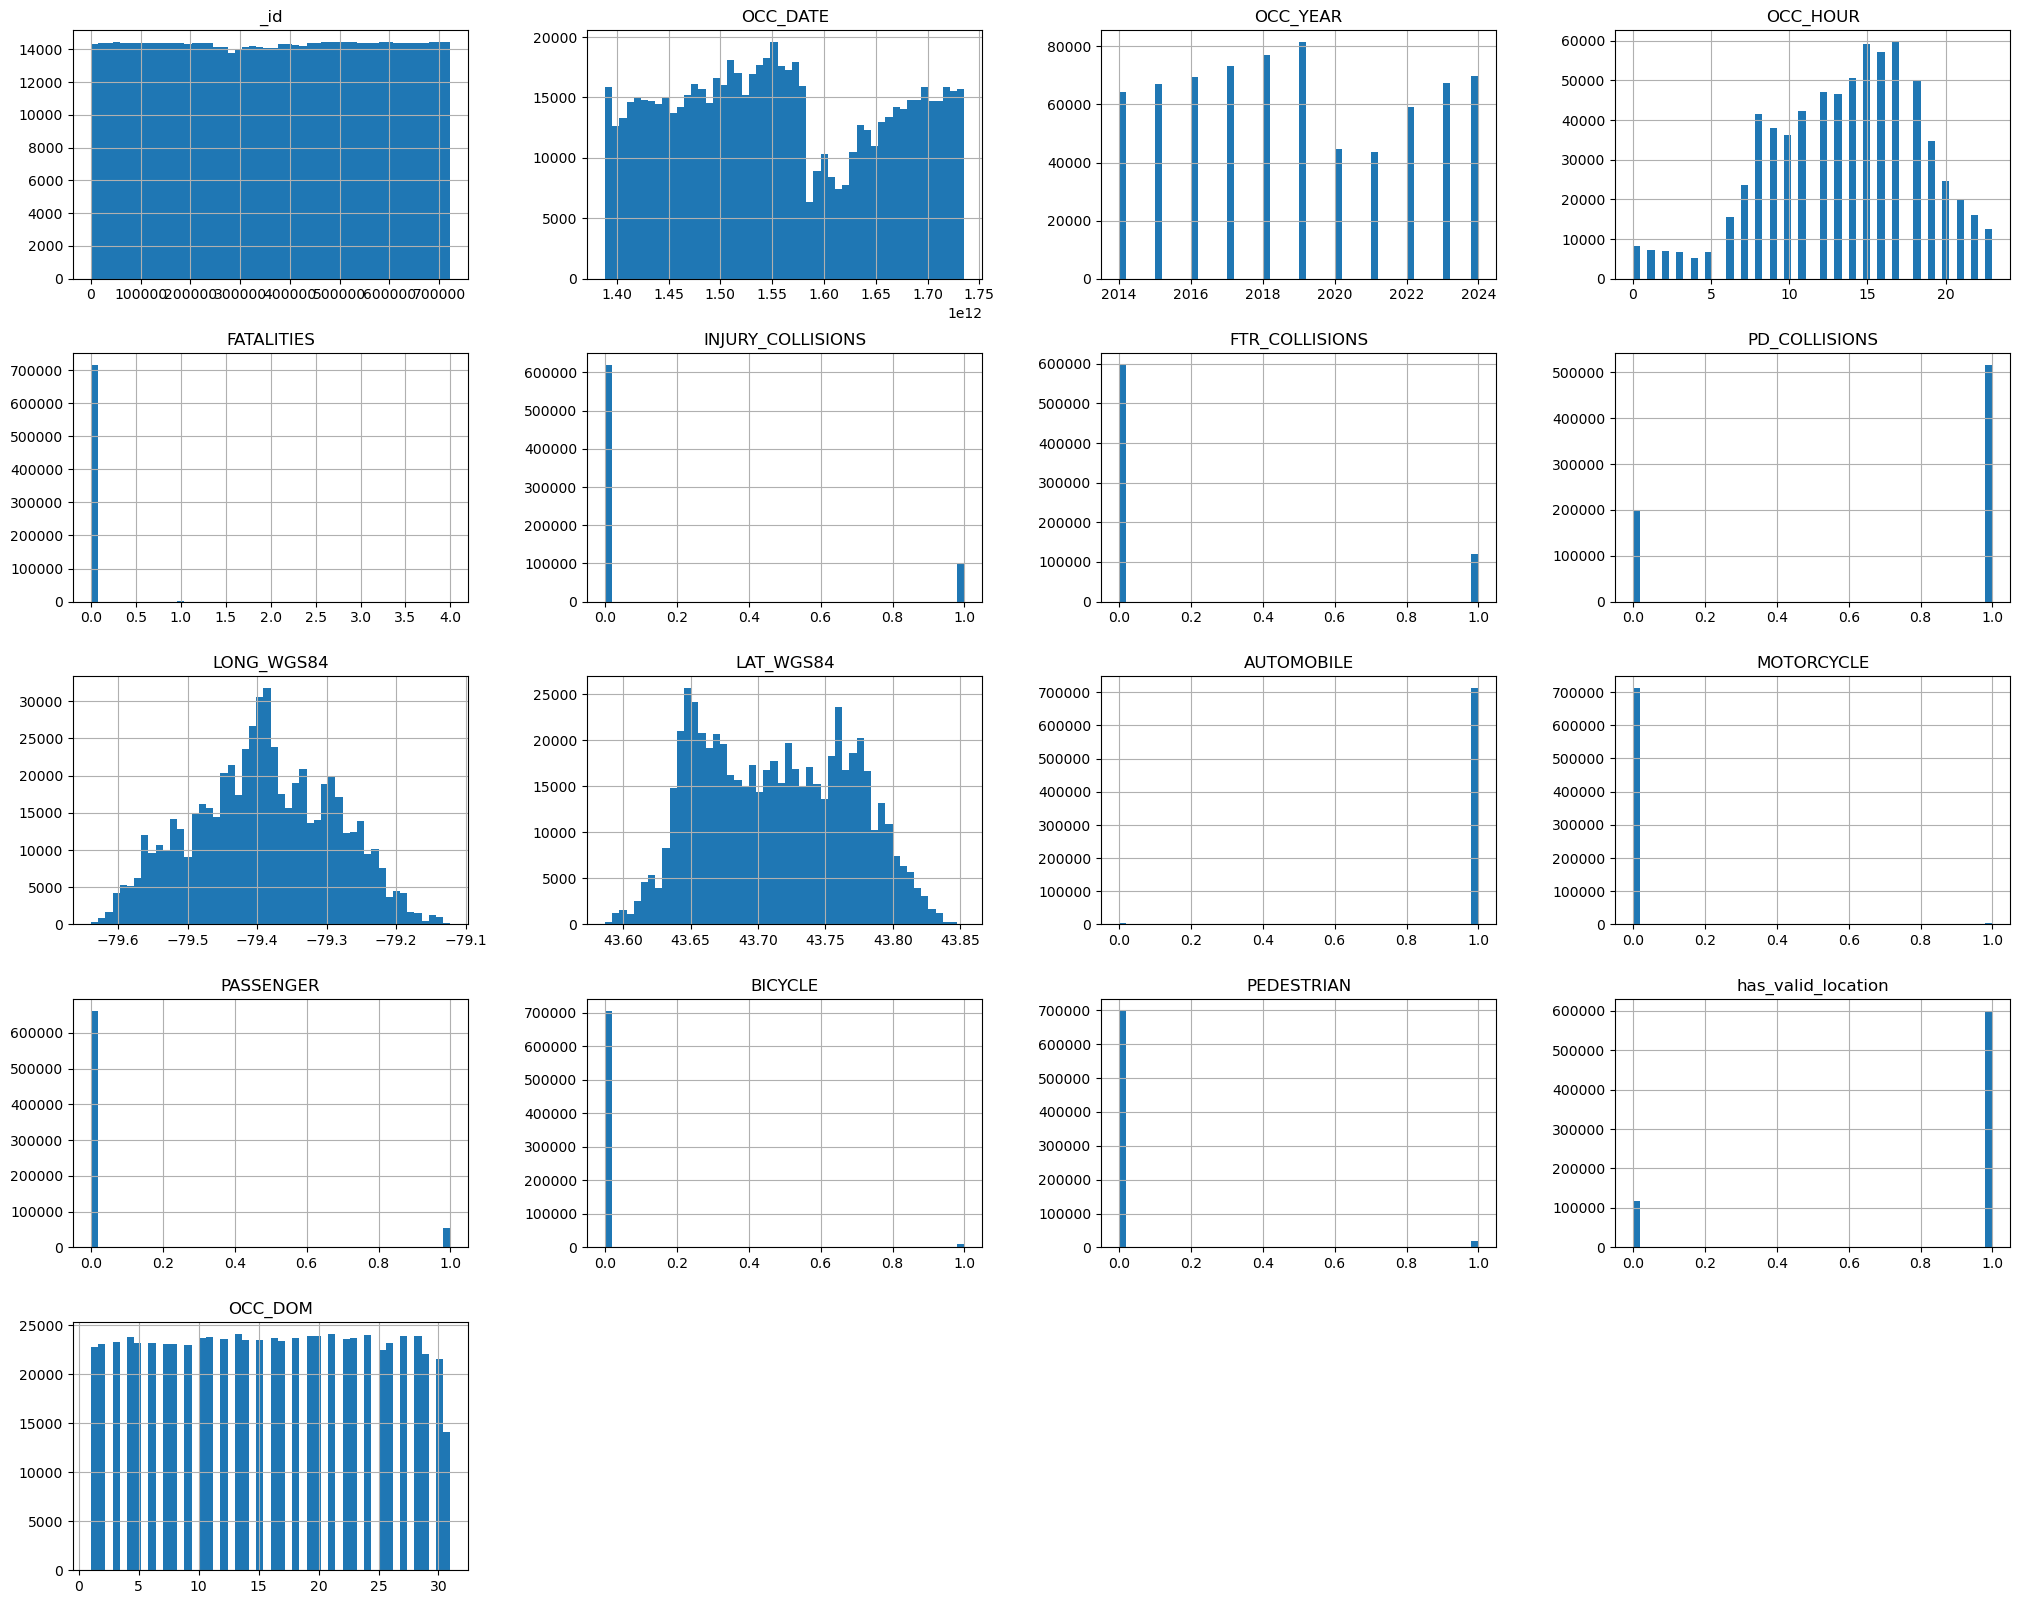

In [ ]:
# get the summary histogram plot
query_1 = "SELECT * FROM collisions"
gdf_all = gpd.read_postgis(query_1, engine, geom_col="geometry")
gdf_all.hist(bins=50, figsize=(25, 20))

2. plot the hist of no. of car collision by day of the week

<AxesSubplot:title={'center':'No.of collisions by the day of week'}, xlabel='OCC_DOW'>

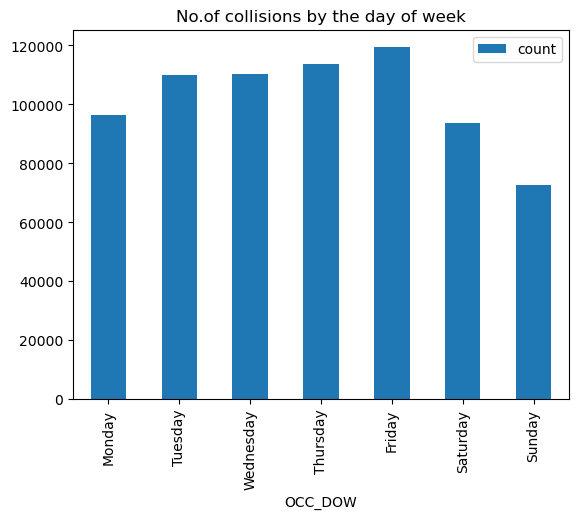

In [58]:
query_2 = """
SELECT "OCC_DOW", COUNT(*)
FROM collisions
GROUP BY "OCC_DOW"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
END)
"""
df_collisions_by_week = pd.read_sql_query(query_2, engine)
df_collisions_by_week.plot.bar(x='OCC_DOW', y='count', title="No.of collisions by the day of week")


3. Investiagte the peak hour of collision of the day in each day of the week


In [ ]:
query_3 = """
SELECT "OCC_DOW", "OCC_HOUR", COUNT(*)
FROM collisions
GROUP BY "OCC_DOW", "OCC_HOUR"
ORDER BY (CASE
    WHEN "OCC_DOW"='Monday' THEN 1
    WHEN "OCC_DOW"='Tuesday' THEN 2
    WHEN "OCC_DOW"='Wednesday' THEN 3
    WHEN "OCC_DOW"='Thursday' THEN 4
    WHEN "OCC_DOW"='Friday' THEN 5
    WHEN "OCC_DOW"='Saturday' THEN 6
    ELSE 7
    END), "OCC_HOUR"
"""
df_day_hour = pd.read_sql_query(query_3, engine)
df_day_hour


OCC_DOW  OCC_HOUR  count
0    Monday         0   1007
1    Monday         1    850
2    Monday         2    777
3    Monday         3    831
4    Monday         4    703
..      ...       ...    ...
163  Sunday        19   3628
164  Sunday        20   3007
165  Sunday        21   2419
166  Sunday        22   1938
167  Sunday        23   1505

[168 rows x 3 columns]

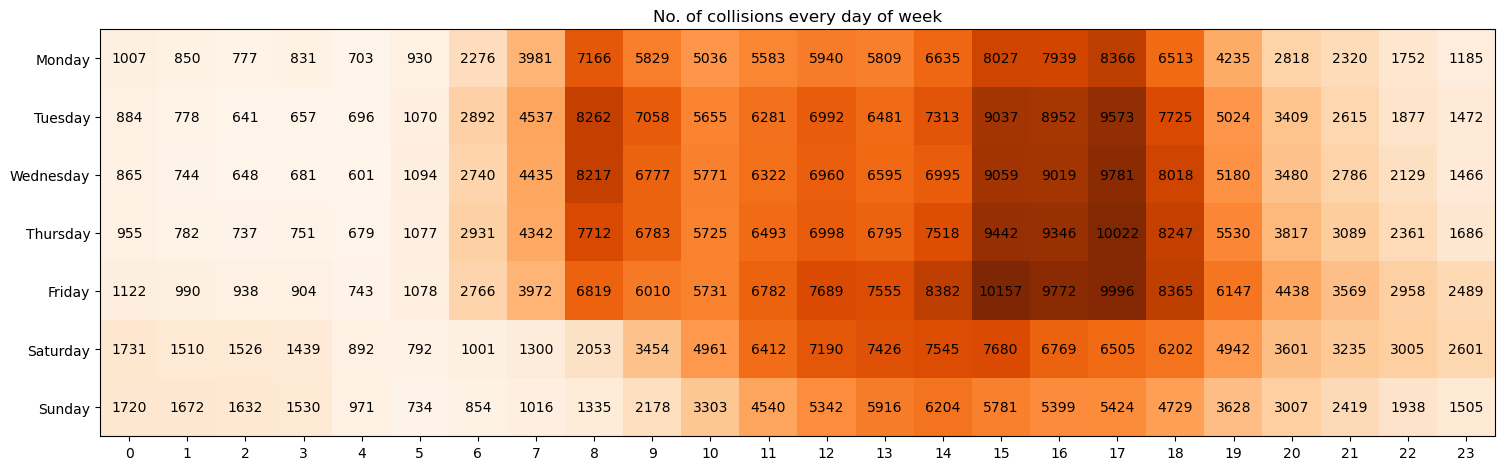

In [50]:
# turn count into 2d matrix
count = df_day_hour['count']

# data
day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data = []
for i in range(7):
    row = []
    for j in range(24):
        row.append(count.iloc[i *24 + j])
    data.append(row)

fig, ax = plt.subplots(figsize=(18,8))
im = ax.imshow(data, cmap="Oranges")

# set title
ax.set_title("No. of collisions every day of week")

# label the axis
ax.set_xticks(range(24))
ax.set_yticks(range(len(day_of_week)), labels=day_of_week)

# text annotations
for i in range(7):
    for j in range(24):
        text = ax.text(j, i, data[i][j],
                       ha="center", va="center")

# set size


plt.show()


It is observed that the no. of collisions on friday night, particularly friday towards midnight is higher than that of other weekdays. 
(2489 on friday 2300 vs. 1686 on thursday 2300 - around 50% increase!)

We would like to conduct further analysis.
Firstly, do note there are cases of collisions that does not an specified address. It is suspected that the reporting process is abrupt.
We would like to see if the NSA ratio is the same for cases happening in friday 2300 vs. 2300 of other days of the week.

In [81]:
valid_collision_count = []
nsa_collision_count = []

for day in day_of_week:
    query_4_nsa_ratio = f"""SELECT COUNT(*) FROM collisions WHERE ("OCC_DOW" = '{day}') and ("OCC_HOUR" = 23) and (has_valid_location = 1)"""
    df = pd.read_sql_query(query_4_nsa_ratio, engine)
    valid_collision_count.append(df.iloc[0, 0])

for day in day_of_week:
    query_4_nsa_ratio = f"""SELECT COUNT(*) FROM collisions WHERE ("OCC_DOW" = '{day}') and ("OCC_HOUR" = 23) and (has_valid_location = 0)"""
    df = pd.read_sql_query(query_4_nsa_ratio, engine)
    nsa_collision_count.append(df.iloc[0, 0])

print(valid_collision_count)
print(nsa_collision_count)

[1022, 1262, 1259, 1475, 2128, 2239, 1269]
[163, 210, 207, 211, 361, 362, 236]


In [ ]:
query_4_fri = """
SELECT *
FROM collisions
WHERE ("OCC_DOW" = 'Friday') and ("OCC_HOUR" = 23)
"""

query_4_thurs = """
SELECT *
FROM collisions
WHERE ("OCC_DOW" = 'Friday') and ("OCC_HOUR" = 23)
"""

gdf_4_fri = gpd.read_postgis(query_4_fri, engine, geom_col="geometry")
gdf_4_thurs = gpd.read_postgis(query_4_thurs, engine, geom_col="geometry")

In [66]:
gdf_4_fri.explore(legend=True)

In [67]:
gdf_4_thurs.explore(legend=True)